2024-10-14 11:33:50.508972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 11:33:50.518404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:33:50.529383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:33:50.532553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 11:33:50.540456: I tensorflow/core/platform/cpu_feature_guar

Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Found 1650 files belonging to 2 classes.
Using 330 files for validation.
Index(['filepath', 'label'], dtype='object')


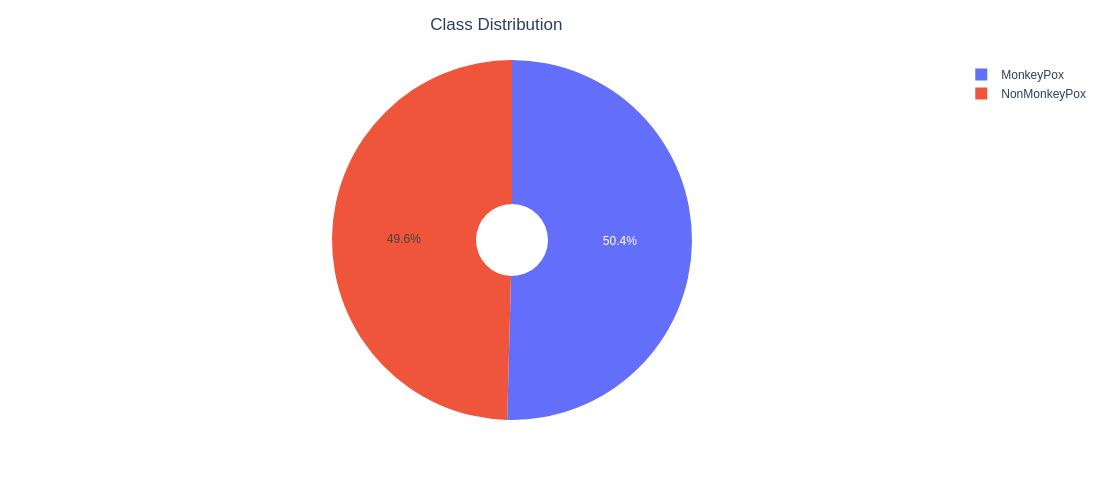

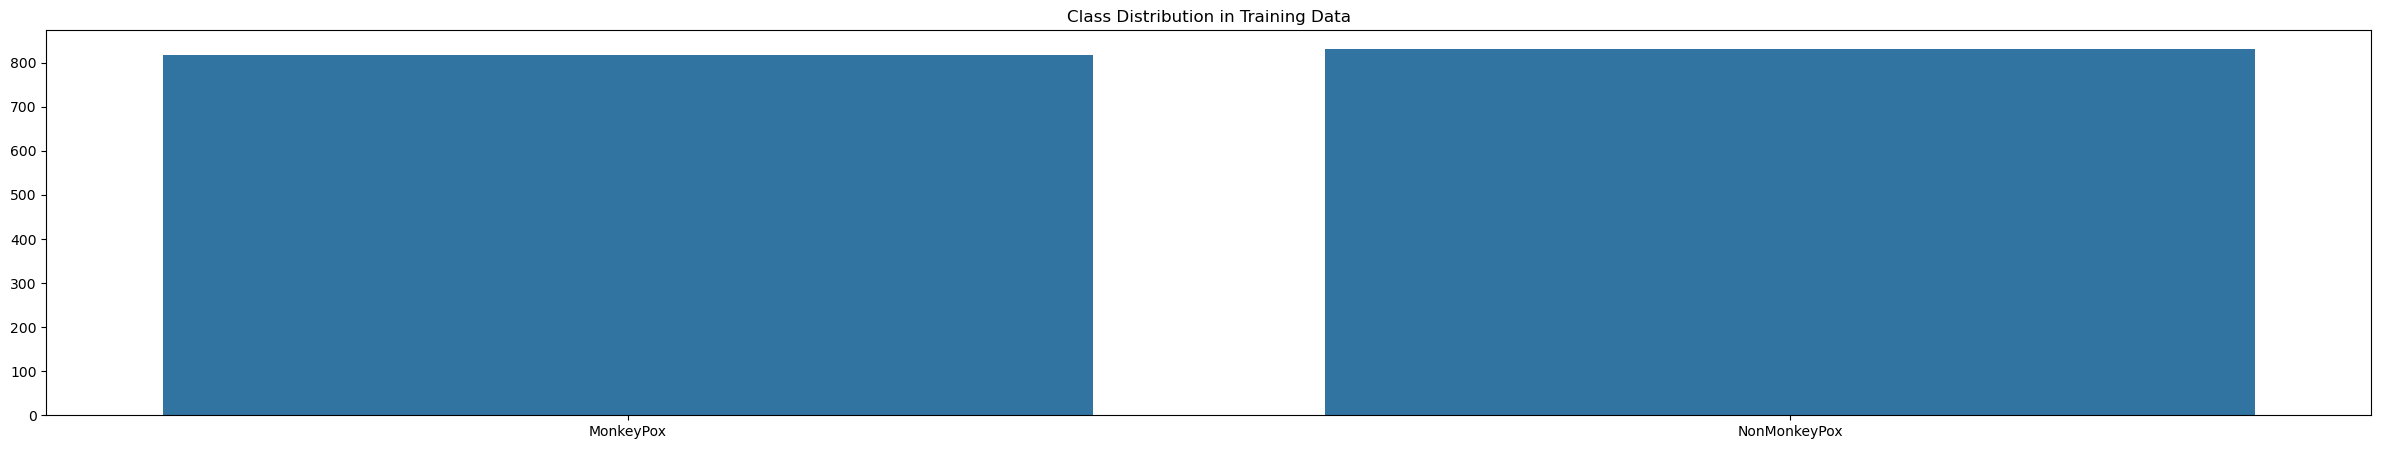

In [1]:
# Required Libraries
import numpy as np 
import pandas as pd 
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optional - Install Plotly if not already installed
# !pip install plotly

# Plotly for visualization
import plotly.express as px

# Define image dimensions and batch size
image_height = 224
image_weight = 224
batch_size = 32

# Specify the path to your dataset
tpath = 'aug'  # Update this with your local path

# Load the training data using ImageDataGenerator
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

# Load the validation data
validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

# Load the metadata information (Update the path)
info_file = 'labels_aug.csv'  # Update the path
info = pd.read_csv(info_file)
info.head()

# Check the column names to be sure
print(info.columns)

# Correct the pie chart code to use the lowercase 'label'
fig = px.pie(
    names=info['label'].unique(),  # Corrected to 'label'
    values=info['label'].value_counts(),  # Corrected to 'label'
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Class Distribution', 'x': 0.45}})
fig.show()

# Visualize class distribution in a bar plot
class_names = []
class_count = []
train_examples = 0

# Count the number of images per class
for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

# Display class distribution as a bar plot
plt.figure(figsize=(30, 5))
sns.barplot(x=class_names, y=class_count)
plt.title("Class Distribution in Training Data")
plt.show()


Found 1321 images belonging to 2 classes.


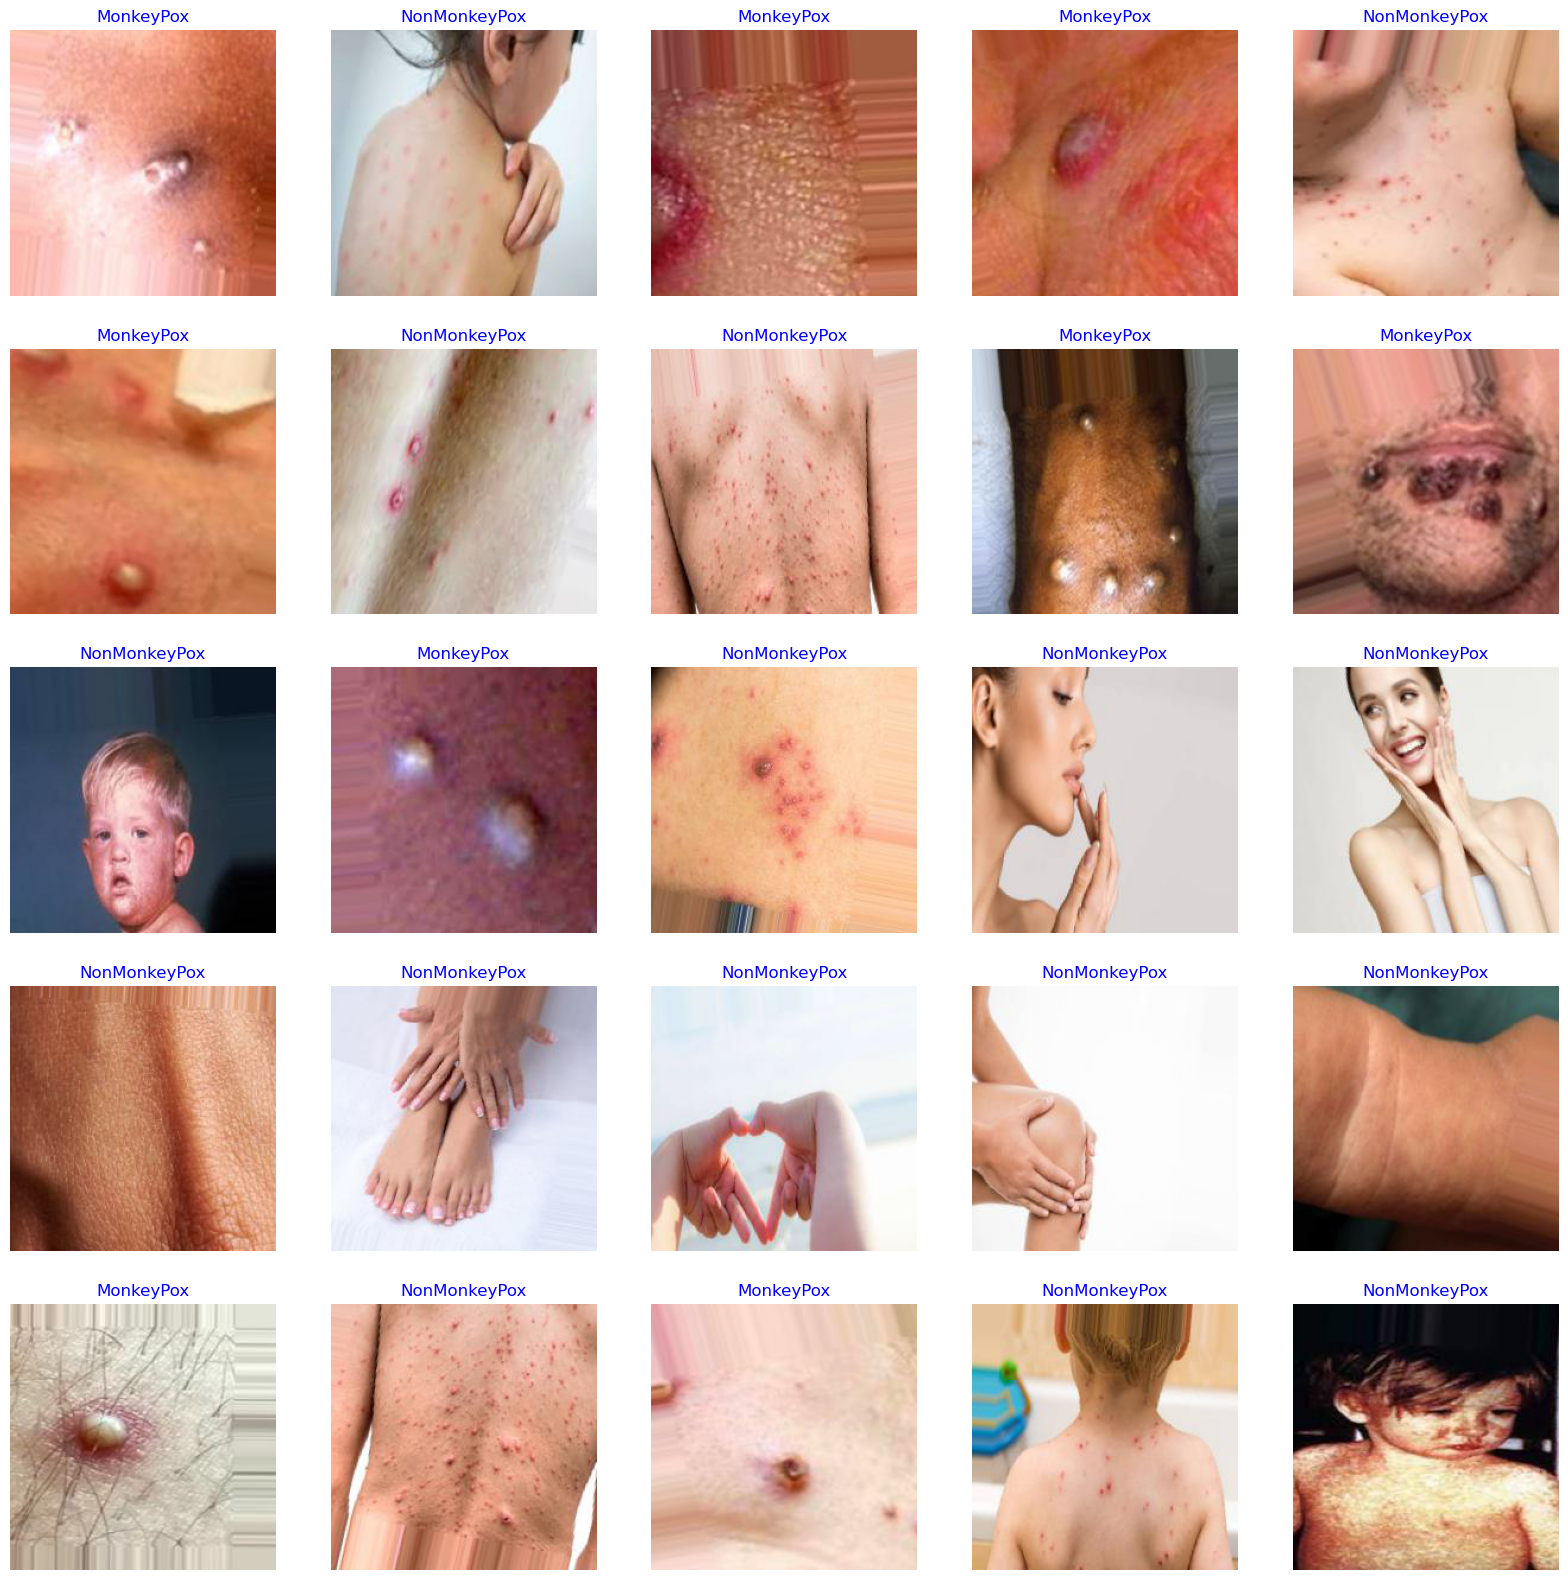

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
tpath = "aug"  # Example: 'data/' containing 'monkeypox' and 'nonmonkeypox'

# Create an ImageDataGenerator for rescaling without augmentation
train_gen = ImageDataGenerator(
    rescale=1. / 255,             # Normalizes the pixel values to the range [0, 1]
    validation_split=0.2          # Splits 20% of the data for validation
)

# Load images from the directory for training
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(224, 224),        # Resize all images to 224x224
    batch_size=32,                 # Number of images to return in each batch
    subset='training',             # Specify as training data (80% of data)
    shuffle=True                   # Shuffle the images to randomize the batch
)

# Get class indices (which class corresponds to which folder)
g_dict = train_batch.class_indices  # Returns a dictionary like {'monkeypox': 0, 'nonmonkeypox': 1}
classes = list(g_dict.keys())       # List of class names: ['monkeypox', 'nonmonkeypox']

# Get a batch of images and labels
images, labels = next(train_batch)  # Fetch a batch of images and corresponding labels

# Determine the number of images to display (up to 30)
length = len(labels)        # Length of batch size (16 in this case)
sample = min(length, 25)    # Display up to 30 images (or batch size if smaller)

# Set up the plot for displaying images
plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]      # Image from the batch
    plt.imshow(image)      # Display the image
    index = np.argmax(labels[i])  # Get the index of the class label (0 or 1)
    class_name = classes[index]   # Get the class name ('monkeypox' or 'nonmonkeypox')
    plt.title(class_name, color='blue', fontsize=12)  # Set title to class name
    plt.axis('off')        # Hide axis for better display

plt.show()


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create a Sequential model
MobileNet_model = Sequential()

# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layers
pretrained_model = MobileNetV2(include_top=False,
                               input_shape=(224, 224, 3),  # Input shape
                               pooling='avg',  # Global average pooling
                               weights='imagenet')

# Freeze the pre-trained layers to avoid updating their weights during training
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained MobileNetV2 model to the Sequential model
MobileNet_model.add(pretrained_model)

# Flatten the output from the pre-trained model
MobileNet_model.add(Flatten())

# Add a dropout layer for regularization (helps prevent overfitting)
MobileNet_model.add(Dropout(0.5))  # 50% dropout rate

# Add custom dense layers
MobileNet_model.add(Dense(512, activation='relu'))  # Fully connected hidden layer
MobileNet_model.add(Dense(2, activation='softmax'))  # Output layer for 2 classes (MonkeyPox and Other)

# Display the model summary
MobileNet_model.summary()




Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Compile the model using Adam optimizer
MobileNet_model.compile(loss='sparse_categorical_crossentropy', 
                        optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a small learning rate
                        metrics=['accuracy'])

# Set the number of epochs
epochs = 50

# Train the model
history1 = MobileNet_model.fit(
    training_data,           # Generator or dataset for training data
    validation_data=validation_data,  # Generator or dataset for validation data
    epochs=epochs,           # Number of epochs for training
    verbose=1                # Show training progress
)

# Save the trained model for future use
MobileNet_model.save('mobilenetV2.h5')

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 950ms/step - accuracy: 0.7080 - loss: 0.6188 - val_accuracy: 0.8727 - val_loss: 0.3103
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 920ms/step - accuracy: 0.8065 - loss: 0.4368 - val_accuracy: 0.8909 - val_loss: 0.2771
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 912ms/step - accuracy: 0.8413 - loss: 0.3823 - val_accuracy: 0.9000 - val_loss: 0.2639
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 926ms/step - accuracy: 0.8286 - loss: 0.3718 - val_accuracy: 0.8909 - val_loss: 0.2568
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 912ms/step - accuracy: 0.8439 - loss: 0.3614 - val_accuracy: 0.9030 - val_loss: 0.2420
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 917ms/step - accuracy: 0.8516 - loss: 0.3301 - val_accuracy: 0.9152 - val_loss: 0.2331
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 917ms/step - accuracy: 0.8719 - loss: 0.3124 - val_accuracy: 0.9182 - val_loss: 0.2312
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 916ms/step - accuracy: 0.8864 - loss: 0.2911 - val_accu

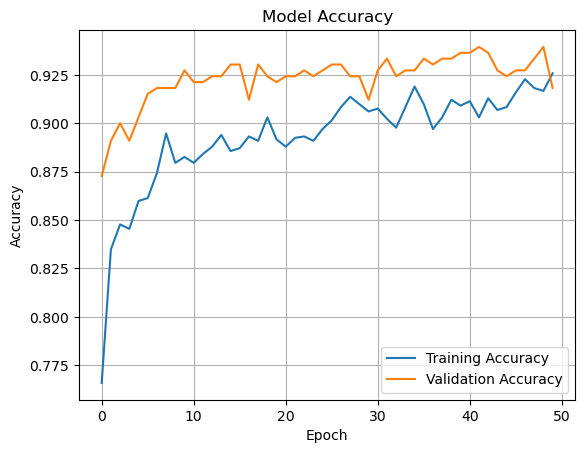

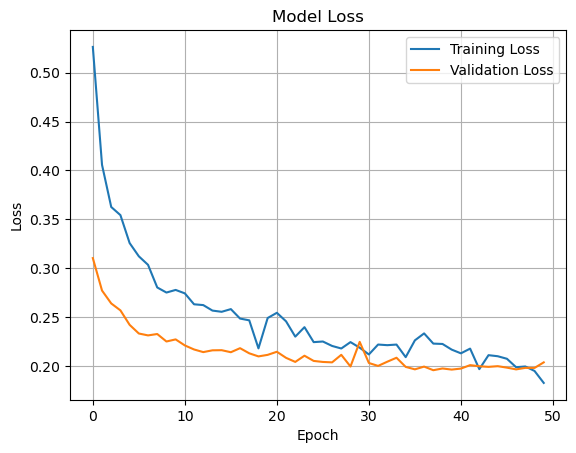

In [18]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


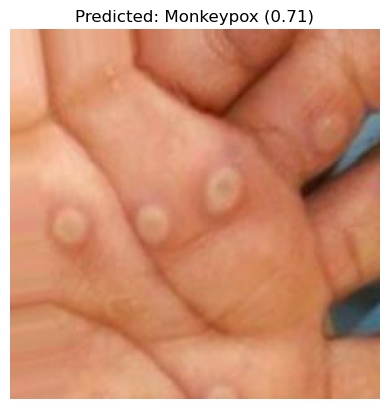

Prediction probabilities: [0.71019167 0.2898083 ]


In [19]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/mp/mp1.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


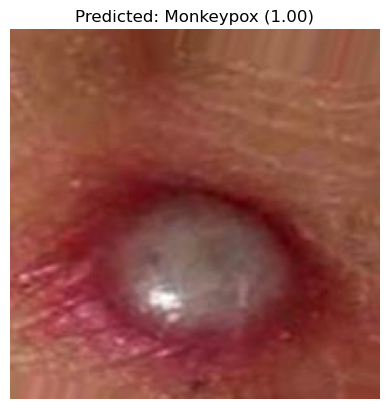

Prediction probabilities: [0.9957722  0.00422782]


In [20]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/mp/mp2.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


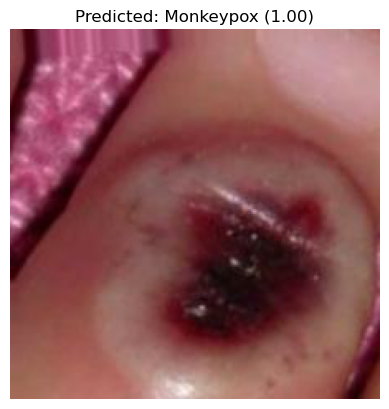

Prediction probabilities: [0.9960401  0.00395992]


In [21]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/mp/mp3.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


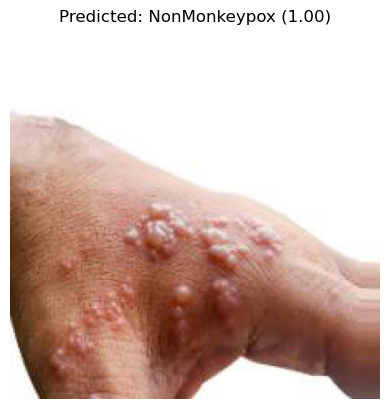

Prediction probabilities: [1.5757413e-04 9.9984241e-01]


In [22]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/nonmp/nonmp1.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


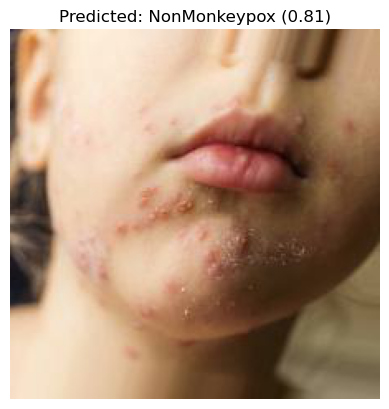

Prediction probabilities: [0.18717504 0.81282496]


In [24]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/nonmp/nonmp2.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


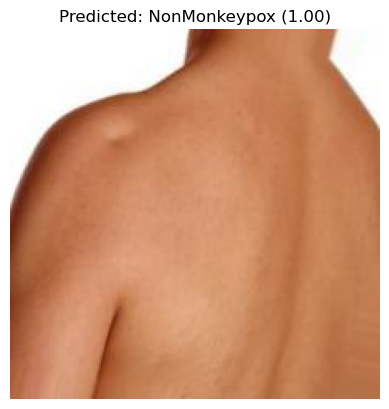

Prediction probabilities: [0.00482228 0.99517775]


In [25]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


resnet_model = load_model('mobilenetV2.h5')

# Load and preprocess the image
img_path = 'test/nonmp/nonmp3.jpg'
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Make prediction using the trained MobileNetV2 model
y_pred = resnet_model.predict(x)

# Define class labels
class_names = ['Monkeypox', 'NonMonkeypox']

# Get the predicted class index and corresponding class name
class_idx = np.argmax(y_pred, axis=1)[0]
class_name = class_names[class_idx]

confidence = np.max(y_pred) 

# Display the image with the predicted class label
plt.imshow(img)
plt.title(f"Predicted Class: {class_name}")
plt.title(f'Predicted: {class_name} ({confidence:.2f})')
plt.axis('off')  # Turn off the axis display
plt.show()

# Optional: Display the actual prediction probabilities for each class
predicted_probabilities = y_pred[0]
print(f'Prediction probabilities: {predicted_probabilities}')